In [110]:
import pandas as pd
import numpy as np
import openpyxl
import os
import glob
import matplotlib.pyplot as plt

In [111]:
def read_excel(file):
    df = pd.read_excel(file)
    return df

df = read_excel('../../Data/Processed data/lstm_dmc.xlsx')

In [112]:
# convert Date field to float
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'].values.astype(float)
#sort by date
df = df.sort_values(by='Date')
# for rows where df['Affected'] is null or non-numeric, replace with 0
df['Affected'] = pd.to_numeric(df['Affected'], errors='coerce').fillna(0).astype(float)
df.reset_index(drop=True, inplace=True)

In [113]:
# defining hyperparameters
num_epochs = 500
learning_rate = 0.001
batch_size = 32
window_size = 14
prediction_window = 3
input_size = window_size - prediction_window
hidden_size = 64
num_layers = 1

print("num_epochs: ", num_epochs, " learning_rate: ", learning_rate, " batch_size: ", batch_size, " window_size: ", window_size, " input_size: ", input_size, " num_layers: ", num_layers)

num_epochs:  500  learning_rate:  0.001  batch_size:  32  window_size:  14  input_size:  11  num_layers:  1


In [114]:

def create_time_series_samples(df, window_size):
    samples = []

    for i in range(len(df) - window_size + 1):
        sample = df.iloc[i:i + window_size]
        samples.append(sample)

    return samples



samples = create_time_series_samples(df, window_size)

In [115]:
affected_df = pd.DataFrame([sample['Affected'].values for sample in samples])
affected_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,92.0,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0
1,82.0,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0
2,64.0,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0
3,47.0,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0
4,63.0,61.0,33.0,52.0,81.0,49.0,51.0,40.0,34.0,36.0,39.0,46.0,47.0,35.0


In [116]:
def train_test_split(df, split_ratio, shuffle):
    if shuffle:
        df = df.sample(frac=1)

    split_index = int(len(df) * split_ratio)
    train = df[:split_index]
    test = df[split_index:]

    return train, test

train_df , test_df = train_test_split(affected_df, 0.8, True)

In [117]:
def split_X_y(df):
    #last prediction_window columns are y
    y = df.iloc[:, -prediction_window:]
    #first window_size - prediction_window columns are X
    X = df.iloc[:, :input_size]
    return X, y

X_train, y_train = split_X_y(train_df)
X_test, y_test = split_X_y(test_df)

In [118]:
# Run transformer model from pytorch on Train and Test data
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.values).float()
y_train_tensor = torch.tensor(y_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
y_test_tensor = torch.tensor(y_test.values).float()


In [119]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, shuffle=False)

In [120]:
len(train_loader), len(test_loader)

(18, 5)

In [121]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(TransformerModel, self).__init__()
        self.encoder = nn.TransformerEncoderLayer(d_model=input_size, nhead=1)
        self.fc = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(0.1)
        self.output = nn.Linear(hidden_size, prediction_window)

    def forward(self, x):
        x = self.encoder(x)
        x = self.fc(x)
        x = self.dropout(x)
        x = self.output(x)
        return x
model = TransformerModel(input_size, hidden_size, num_layers)

In [122]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [123]:
#train the model
for epoch in range(num_epochs):
    for i, (X, y) in enumerate(train_loader):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y.unsqueeze(1))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

e:\Installation\Anaconda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 3])) that is different to the input size (torch.Size([32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
e:\Installation\Anaconda\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 3])) that is different to the input size (torch.Size([4, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [50/500], Loss: 281.7710
Epoch [100/500], Loss: 231.9990
Epoch [150/500], Loss: 498.8440
Epoch [200/500], Loss: 789.4039
Epoch [250/500], Loss: 237.6857
Epoch [300/500], Loss: 232.7728
Epoch [350/500], Loss: 802.0378
Epoch [400/500], Loss: 490.2143
Epoch [450/500], Loss: 2123.8118
Epoch [500/500], Loss: 434.4754


In [124]:
# Test the model
predictions = []
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for X, y in test_loader:
        outputs = model(X)
        predicted = torch.round(outputs)
        predictions.append(predicted)
        total += y.size(0)
        correct += (predicted == y.unsqueeze(1)).sum().item()

    print('Test Accuracy of the model on the test data: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test data: 27.00729927007299 %


In [125]:
predictions

[tensor([[19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.]]),
 tensor([[19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [19., 19., 19.],
         [

In [126]:
# get the first column of y_test_tensor
y_test_1 = y_test_tensor[:, 0].numpy()

In [127]:
y_test.shape, len(predictions)

((137, 3), 5)

In [128]:
# convert predictions to numpy array
predictions_array = [prediction.numpy() for prediction in predictions]
predictions_array = np.concatenate(predictions_array, axis=0)
predictions_array.shape
predicted_1 = predictions_array[:, 0]

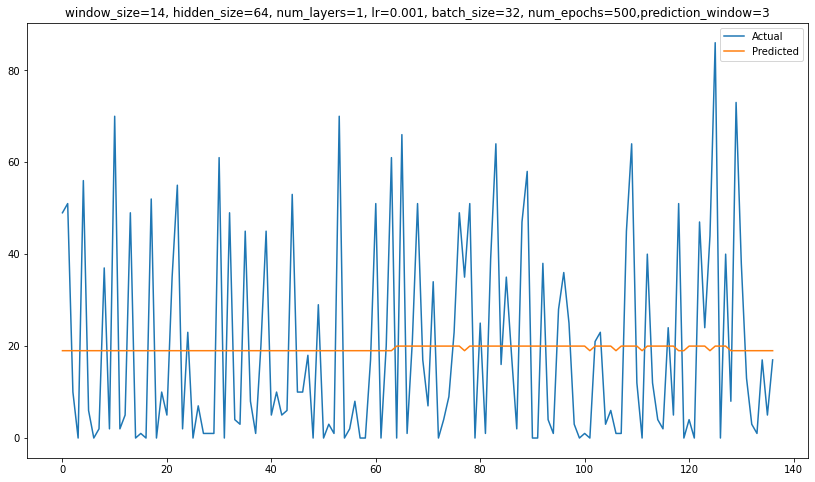

In [131]:
#plot the predictions and actual 
plt.figure(figsize=(14, 8))
plt.title(f'window_size={window_size}, hidden_size={hidden_size}, num_layers={num_layers}, lr={learning_rate}, batch_size={batch_size}, num_epochs={num_epochs},prediction_window={prediction_window}')
plt.plot(y_test_1, label='Actual')
plt.plot(predicted_1, label='Predicted')
# plt.plot(y_test.values, label='Actual')
# plt.plot(torch.cat(predictions).numpy(), label='Predicted')
plt.legend()
plt.show()

In [130]:
#MAE, MSE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test.values, torch.cat(predictions).numpy())
mse = mean_squared_error(y_test.values, torch.cat(predictions).numpy())
rmse = np.sqrt(mse)
mae, mse, rmse
print("MAE: ", mae, " MSE: ", mse, " RMSE: ", rmse)

MAE:  18.75669099756691  MSE:  489.647201946472  RMSE:  22.127973290531422
